- import libraries

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

- read ecog data

In [2]:
dataset_dir = 'data/Origin/withoutICA/ECoGICA_'
freq_list = [700,800,900,1000,1100,1200,1300,1400,1500,1600]
data_file_num = []
column_list=[]
for i in range(1, 12501):
    column_list.append(i)
for ii in range(10):
    data_file_num.append(0)
# print(data_file_num)
for iii in range(10):
    data_file = dataset_dir + str(freq_list[iii]) + '.txt'
    data_np=pd.read_csv(data_file, sep='\t', header=None).loc[1: , column_list].to_numpy()
    data_np_sp = data_np.reshape(100, 96, 125).astype(np.float32)
    data_file_num[iii] = data_np_sp

C:\Users\Hyde\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


125
-1505.7513


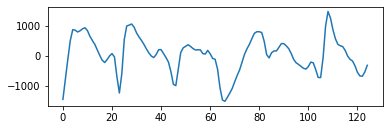

In [3]:
print(np.size(data_file_num[0][0][0]))
print(data_file_num[0][0][0].min())
fig=plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(data_file_num[0][0][0])

- Max-min normalization

In [4]:
for j in range(10):
    for jj in range(100):
        for jjj in range(96):
            ecog_ch = data_file_num[j][jj][jjj]
            ch_max = ecog_ch.max()
            ch_min = ecog_ch.min()
            ecog_norm = []
            for jjjj in range(125):
                ecog_norm.append((ecog_ch[jjjj]-ch_min)/(ch_max-ch_min))
            data_file_num[j][jj][jjj] = ecog_norm

[0.02156463 0.24615367 0.467743   0.67579275 0.79709524 0.79165614
 0.7716046  0.78502905 0.8066572  0.8184588  0.7865212  0.723272
 0.6765702  0.63361406 0.5719684  0.5116981  0.45740628 0.43163356
 0.4640453  0.5051603  0.531077   0.49355718 0.27338082 0.09284618
 0.30901223 0.6886878  0.8386978  0.84822285 0.8602985  0.82517594
 0.7615912  0.7164727  0.67799795 0.63412154 0.58359283 0.5389789
 0.50398815 0.48675266 0.52043915 0.57468003 0.5752693  0.53032595
 0.48706388 0.43578786 0.3295664  0.189543   0.17478345 0.35824394
 0.54306644 0.5947937  0.61225635 0.6295591  0.6104096  0.5866751
 0.57157904 0.5731552  0.5726908  0.53042006 0.52652276 0.56652373
 0.5288003  0.47672236 0.46806452 0.35794407 0.14981586 0.01428763
 0.         0.04462745 0.09230716 0.14469256 0.21896625 0.28767318
 0.3504918  0.43678388 0.52447444 0.5851514  0.6353779  0.69848317
 0.75669646 0.77423584 0.77444875 0.76522917 0.6678549  0.52002174
 0.48298076 0.5401458  0.5606485  0.56077576 0.60097325 0.64218736

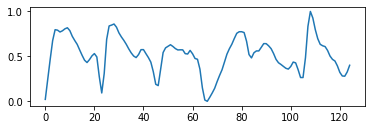

In [6]:
print(data_file_num[0][0][0])
fig=plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(data_file_num[0][0][0])

In [7]:
whole_train_data = []
label_train_data = []
whole_test_data = []
label_test_data = []

label_num = 10
n_epoch = 100

for k in range(10):
    for kk in range(80):
        whole_train_data.append(data_file_num[k][kk])
        label_train_data.append(k)

for kkk in range(10):
    for kkkk in range(20):
        whole_test_data.append(data_file_num[kkk][80+kkkk])
        label_test_data.append(kkk)

In [8]:
whole_train_data = np.array(whole_train_data)
whole_test_data = np.array(whole_test_data)
label_train_data = np.array(label_train_data)
label_test_data = np.array(label_test_data)

In [10]:
whole_train_data[199][95]

array([0.76869756, 0.78936166, 0.8163007 , 0.8275392 , 0.8578121 ,
       0.86537045, 0.7765418 , 0.69769585, 0.69336224, 0.6425213 ,
       0.5312524 , 0.46529767, 0.45787665, 0.43279436, 0.3308816 ,
       0.21425615, 0.16296883, 0.1381918 , 0.12808241, 0.16086818,
       0.2173734 , 0.32076517, 0.45819572, 0.53421205, 0.5906321 ,
       0.7582864 , 0.959136  , 1.        , 0.9283875 , 0.8889723 ,
       0.8134523 , 0.6750816 , 0.5836299 , 0.5177705 , 0.46283418,
       0.46205148, 0.43866235, 0.3961579 , 0.41556716, 0.4149892 ,
       0.36519477, 0.3684914 , 0.39683175, 0.44875464, 0.6510913 ,
       0.8934757 , 0.9557475 , 0.8503439 , 0.6180042 , 0.3453917 ,
       0.18529196, 0.06769766, 0.00921379, 0.14542754, 0.2969011 ,
       0.33243328, 0.3013857 , 0.20418751, 0.17762807, 0.22294359,
       0.24382772, 0.38337058, 0.4518964 , 0.23948562, 0.17732467,
       0.34497833, 0.33974537, 0.25194192, 0.29629508, 0.4491335 ,
       0.70091003, 0.82779765, 0.6959537 , 0.62400526, 0.66601

In [11]:
whole_train_data = torch.from_numpy(whole_train_data)
label_train_data = torch.from_numpy(label_train_data)
whole_test_data = torch.from_numpy(whole_test_data)
label_test_data = torch.from_numpy(label_test_data)

In [12]:
final_train_data = TensorDataset(whole_train_data, label_train_data)
final_test_data = TensorDataset(whole_test_data, label_test_data)

In [13]:
save_file = 'data/dataset_96_125_final.pkl'
print(save_file)
print("Creating pickle file ...")
with open(save_file, 'wb') as f:
    pickle.dump([final_train_data,final_test_data], f, -1)
print("Done!")

data/dataset_96_125_final.pkl
Creating pickle file ...
Done!


C:\Users\Hyde\anaconda3\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
